In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aiwithcagri/wind-turbine-gearbox-anomaly-detection-5year-scada")

print("Path to dataset files:", path)

100%|██████████| 6.33M/6.33M [00:00<00:00, 176MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aiwithcagri/wind-turbine-gearbox-anomaly-detection-5year-scada/versions/2


In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

os.listdir(path)

['turbine_5yr_labeled_data.csv', 'turbine_5yr_complex_data.csv']

In [69]:
DATASET_PATH = os.path.join(path, "turbine_5yr_labeled_data.csv")
df = pd.read_csv(DATASET_PATH)
df.head()

,timestamp,gearbox_oil_temp,gearbox_bearing_temp,vibration_x,vibration_y,vibration_z,oil_pressure,particle_count,is_anomaly
0,2025-01-01 00:00:00,60.49,67.06,0.0129,0.0119,0.0149,4.41,120,0
1,2025-01-01 00:10:00,59.88,67.18,0.0125,0.0115,0.0143,4.43,120,0
2,2025-01-01 00:20:00,60.35,66.80,0.0090,0.0083,0.0104,4.31,120,0
3,2025-01-01 00:30:00,60.11,69.30,0.0143,0.0132,0.0165,4.33,120,0
4,2025-01-01 00:40:00,60.77,67.48,0.0167,0.0154,0.0192,4.35,120,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262800 entries, 0 to 262799
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   timestamp             262800 non-null  object 
 1   gearbox_oil_temp      262800 non-null  float64
 2   gearbox_bearing_temp  262800 non-null  float64
 3   vibration_x           262800 non-null  float64
 4   vibration_y           262800 non-null  float64
 5   vibration_z           262800 non-null  float64
 6   oil_pressure          262800 non-null  float64
 7   particle_count        262800 non-null  int64  
 8   is_anomaly            262800 non-null  int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 18.0+ MB


In [6]:
df.describe()

,gearbox_oil_temp,gearbox_bearing_temp,vibration_x,vibration_y,vibration_z,oil_pressure,particle_count,is_anomaly
count,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000
mean,61.087639,68.188161,0.021638,0.019907,0.024884,4.265352,915.571435,0.020928
std,7.538446,7.728958,0.005915,0.005442,0.006803,0.133616,455.547212,0.143145
min,45.860000,52.190000,0.008800,0.008100,0.010200,2.920000,120.000000,0.000000
25%,54.480000,61.440000,0.018900,0.017400,0.021700,4.210000,522.000000,0.000000
50%,61.010000,68.060000,0.021100,0.019400,0.024200,4.270000,916.000000,0.000000
75%,67.540000,74.660000,0.023300,0.021400,0.026800,4.340000,1310.000000,0.000000
max,89.990000,94.700000,0.085900,0.079000,0.098800,4.570000,1708.000000,1.000000


# Analises nos dados

In [10]:
df['is_anomaly'].value_counts()

,count
is_anomaly,
0,257300
1,5500


In [12]:
df_without_timeset = df.drop(columns=['timestamp'])

### Matriz de Correlação de Pearson

Para prever falhas em turbinas eólicas, o primeiro passo não é apenas olhar para cada sensor isoladamente, mas sim entender como eles se comportam em conjunto. A Matriz de Correlação serve como um "mapa de relacionamentos" do sistema. Ela quantifica, em uma escala de -1 a 1, o quanto o comportamento de uma variável (como a temperatura) afeta ou é afetado por outra (como a vibração).

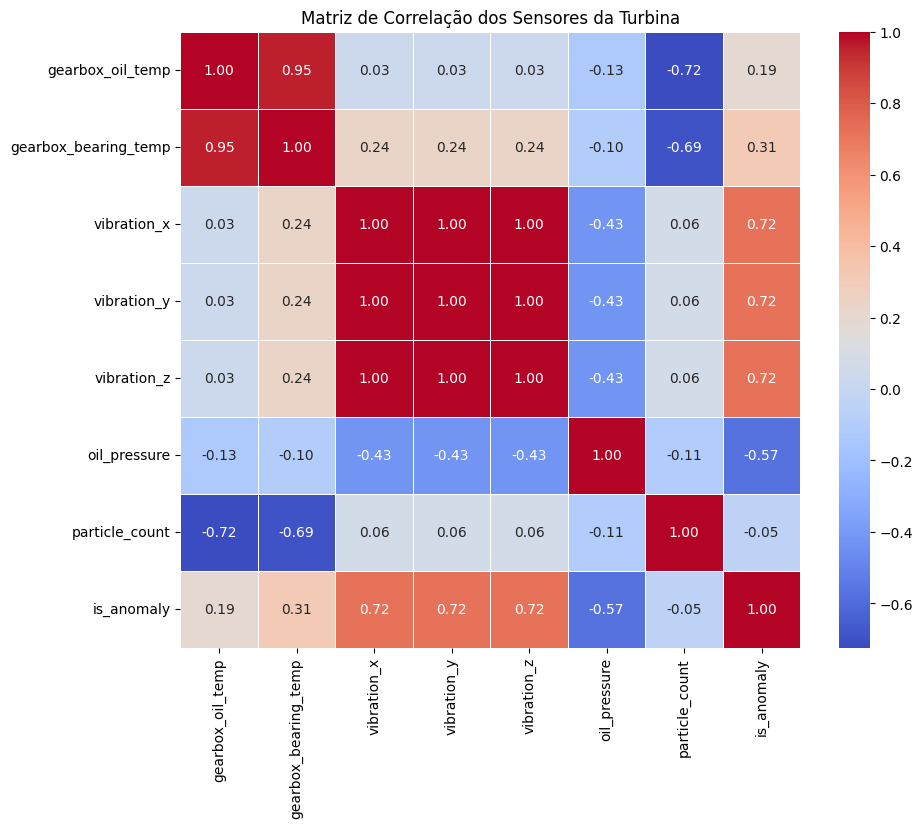

In [13]:
plt.figure(figsize=(10, 8))
corr = df_without_timeset.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação dos Sensores da Turbina')
plt.show()

Através da analise do grafico conseguimos verificar alguns detalhes importantes
Note que as variáveis de vibração (vibration_x, y, z) possuem a maior correlação positiva com `is_anomaly`

O que pode indicar uma forte ligacao entre os valores de vibracao e a presença de falhas.

Alem disso vemos uma correlacao negativa da pressao do oleo em relacao ao `is_anomaly`. Porem, pode indicar uma vazamento de pressao no momento em que se inica a anomalia

Por fim a contagem de particulas possum um valor proximo ao zero, indicando uma correlação nula com a anomalia. Ao contextualiar com o objeto analisado podemos inferir que as anomalias podem tem origens de quebras e nao de desgaste ao longo do tempo.



In [17]:
df_anomaly = df[df['is_anomaly'] == 1]
df_no_anomaly = df[df['is_anomaly'] == 0]

Agora que temos nossas pistas, precisamos entender melhor o comportamento dos dados.

### Analise da vibração

O gráfico de violino é uma excelente ferramenta quando queremos entender a anatomia do dado, comparando a distribuição de uma variável numerica, entre diferentes categorias.

Nesse caso podemos ver uma clara separação de valores entre as diferentes classess da anomalia, onde é percebivel valores mais altos nos eixos de vibraçoes, quando há presença de uma anomalia



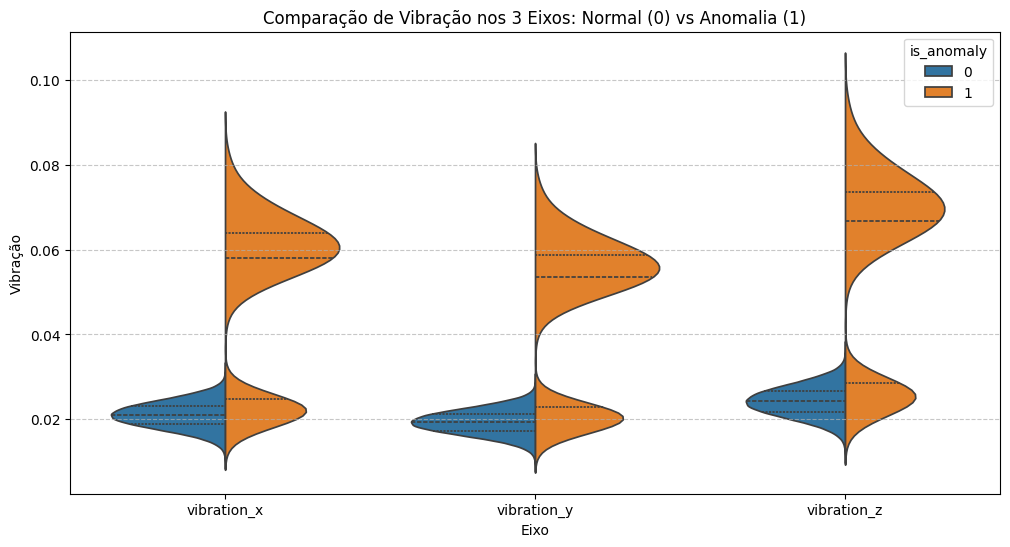

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

vibration_cols = ['vibration_x', 'vibration_y', 'vibration_z', 'is_anomaly']
df_melted = df[vibration_cols].melt(id_vars='is_anomaly', var_name='Eixo', value_name='Vibração')

plt.figure(figsize=(12, 6))
sns.violinplot(x='Eixo', y='Vibração', hue='is_anomaly', data=df_melted, split=True, inner="quart")
plt.title('Comparação de Vibração nos 3 Eixos: Normal (0) vs Anomalia (1)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

De acordo com a correlacao de person, existe tambem uma correlaçao positiva para os valores da temperatura do rolamento e do oleo na preseµça de uma anomalia.

### Analise da temperatura

/tmp/ipython-input-907/2724610231.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_anomaly', y='vibration_x', data=df, palette='Set2')


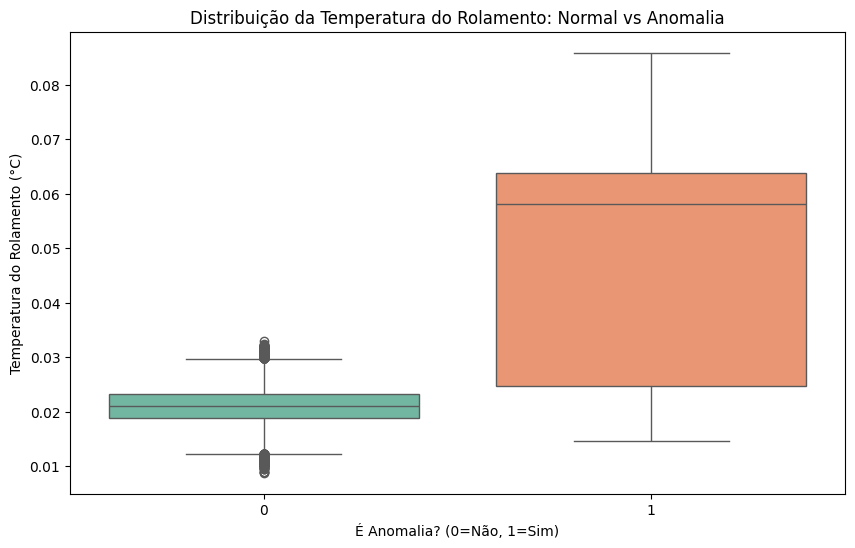

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_anomaly', y='gearbox_bearing_temp', data=df, palette='Set2')
plt.title('Distribuição da Temperatura do Rolamento: Normal vs Anomalia')
plt.xlabel('É Anomalia? (0=Não, 1=Sim)')
plt.ylabel('Temperatura do Rolamento (°C)')
plt.show()

/tmp/ipython-input-907/3847039103.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_no_anomaly['gearbox_oil_temp'], label='Normal', shade=True)
/tmp/ipython-input-907/3847039103.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_anomaly['gearbox_oil_temp'], label='Anomalia', shade=True)


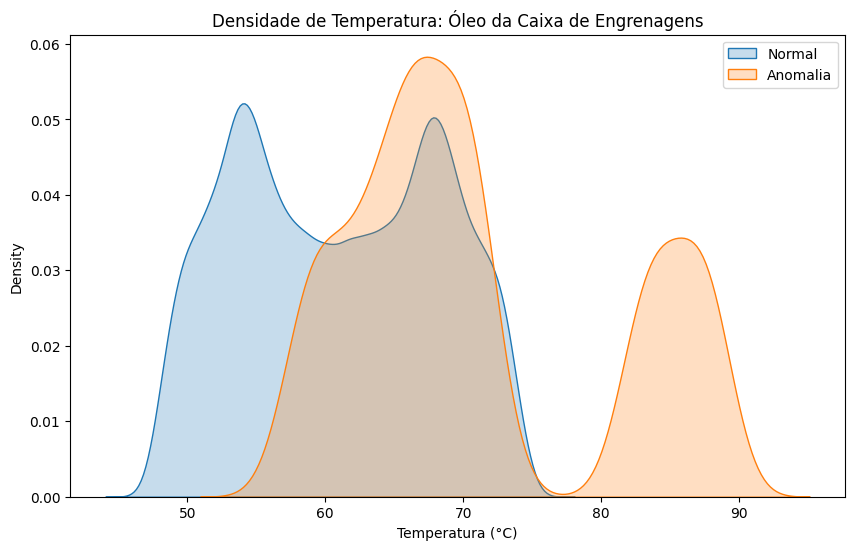

In [26]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_no_anomaly['gearbox_oil_temp'], label='Normal', shade=True)
sns.kdeplot(df_anomaly['gearbox_oil_temp'], label='Anomalia', shade=True)
plt.title('Densidade de Temperatura: Óleo da Caixa de Engrenagens')
plt.xlabel('Temperatura (°C)')
plt.legend()
plt.show()

## Análises temporais

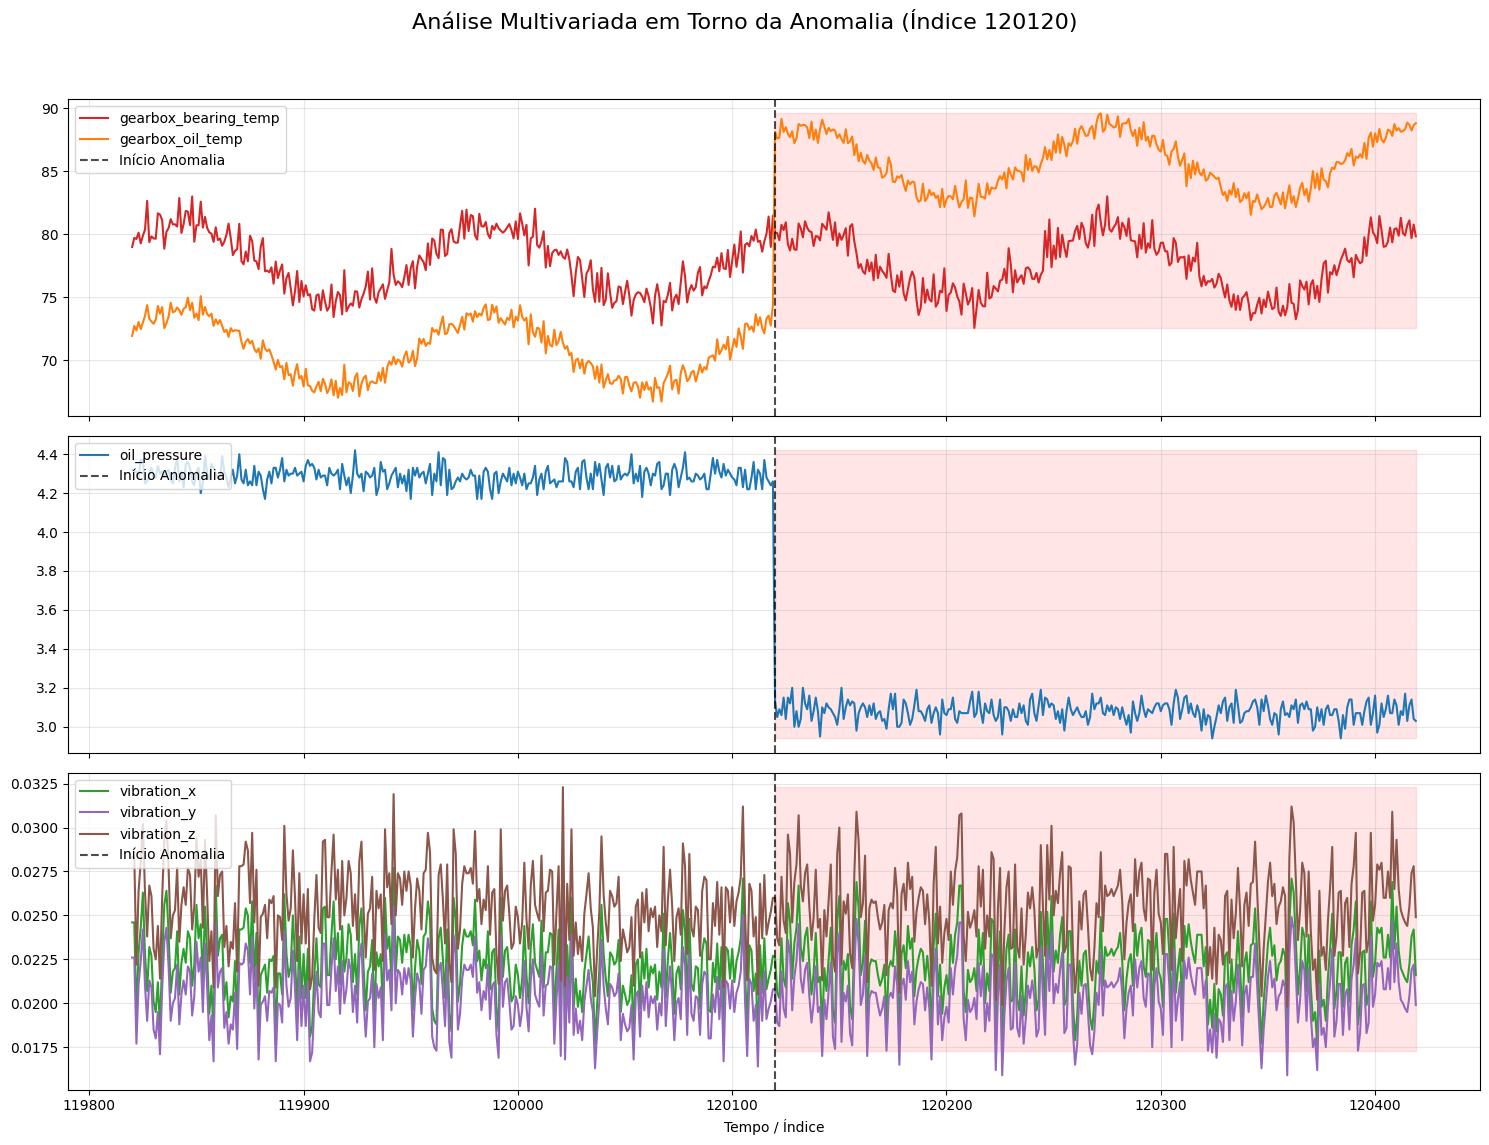

In [48]:
import matplotlib.pyplot as plt

def plot_anomaly_dashboard(df, window_size=300, anomaly_indice=0):

    anomaly_indices = df[df['is_anomaly'] == 1].index

    if len(anomaly_indices) == 0:
        print("Nenhuma anomalia encontrada.")
        return

    idx = anomaly_indices[anomaly_indice]

    start = max(0, idx - window_size)
    end = min(len(df), idx + window_size)
    window_df = df.iloc[start:end]

    #  grupos de sensores para organizar o gráfico
    sensor_groups = [
        ['gearbox_bearing_temp', 'gearbox_oil_temp'],
        ['oil_pressure'],
        ['vibration_x', 'vibration_y', 'vibration_z']
    ]

    fig, axes = plt.subplots(len(sensor_groups), 1, figsize=(15, 12), sharex=True)
    colors = ['tab:red', 'tab:orange', 'tab:blue', 'tab:green', 'tab:purple', 'tab:brown']
    color_idx = 0

    for i, group in enumerate(sensor_groups):
        for sensor in group:
            axes[i].plot(window_df.index, window_df[sensor], label=sensor, color=colors[color_idx % len(colors)])
            color_idx += 1

        # Destaca o momento e o período da anomalia em cada subplot
        axes[i].axvline(x=idx, color='black', linestyle='--', alpha=0.7, label='Início Anomalia')
        axes[i].fill_between(window_df.index, window_df[group[0]].min(), window_df[group[-1]].max(),
                             where=window_df['is_anomaly'] == 1, color='red', alpha=0.1)

        axes[i].legend(loc='upper left')
        axes[i].grid(True, alpha=0.3)

    plt.xlabel('Tempo / Índice')
    plt.suptitle(f'Análise Multivariada em Torno da Anomalia (Índice {idx})', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_anomaly_dashboard(df)

## Lead Time Analysis

O objetivo é descobrir qual sensor indica primeiro que a turbina vai falhar, utilizando como base os 3 desvios padrão.

O uso de 3 desvios padrões ($3\sigma$) não é arbitrário; ele é o padrão ouro na indústria para o  ***Controle Estatístico de Processo.***

Na estatística, se os seus dados seguem uma distribuição normal, existe uma probabilidade matemática fixa para onde os pontos devem cair:

- $1\sigma$ (1 Desvio): Abrange 68% dos dados. (Acontece o tempo todo).
- $2\sigma$ (2 Desvios): Abrange 95% dos dados. (Ainda é considerado comum)
 - $3\sigma$ (3 Desvios): Abrange 99,7% dos dados.

Seguindo essa logica, apenas 0,3% de chance de um sensor apresentar um valor fora dessa faixa por "puro acaso". Se ele cruzou a linha dos $3\sigma$, é quase certo que algo anormal está acontecendo na física da turbina e não é apenas um ruído aleatório.

In [46]:
def calculate_sensor_lead_time(df, window_before=100):
    # Encontrar o início de cada bloco de anomalia
    df['anomaly_start'] = (df['is_anomaly'] == 1) & (df['is_anomaly'].shift(1) == 0)
    event_indices = df[df['anomaly_start']].index

    results = []

    for idx in event_indices:

        lookback_df = df.loc[idx - window_before : idx]
        baseline = df.loc[idx - (window_before*2) : idx - window_before].mean()
        std_dev = df.loc[idx - (window_before*2) : idx - window_before].std()

        event_lead = {"event_index": idx}

        for col in ['gearbox_bearing_temp', 'oil_pressure', 'vibration_z']:
            threshold_high = baseline[col] + (3 * std_dev[col])
            threshold_low = baseline[col] - (3 * std_dev[col])
            trigger = lookback_df[(lookback_df[col] > threshold_high) | (lookback_df[col] < threshold_low)]

            if not trigger.empty:
                lead_steps = idx - trigger.index[0]
                event_lead[col] = lead_steps
            else:
                event_lead[col] = 0

        results.append(event_lead)

    return pd.DataFrame(results)

lead_df = calculate_sensor_lead_time(df_without_timeset)
print(lead_df.mean())

event_index             198886.666667
gearbox_bearing_temp         0.000000
oil_pressure                18.000000
vibration_z                  8.333333
dtype: float64


A pressão do óleo é o melhor indicador antecedente. Ela começa a desviar do padrão normal 18 passos antes da anomalia ser oficialmente registrada pelo sistema SCADA, cada registro sendo de 10 minutos, existe 3 horas de aviso prévio apenas monitorando a queda de pressão.

A vibração no eixo Z avisa a falha com cerca de 8 passos de antecedência, sendo um sinal mais "urgente". Quando ela foge dos $3\sigma$, a quebra está muito próxima (cerca de metade do tempo de aviso da pressão).


# Modelando um previsor de falhas

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

horizonte = 6

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

df['next_failure'] = df['is_anomaly'].shift(-horizonte).rolling(window=horizonte).max().fillna(0)
sensores = ['gearbox_oil_temp', 'gearbox_bearing_temp', 'vibration_z', 'oil_pressure']
for s in sensores:
    df[f'{s}_mean'] = df[s].rolling(window=6).mean()
    df[f'{s}_std'] = df[s].rolling(window=6).std()

df_ml = df.dropna()


Como possuimos um dado extremamente desbalanceado e limitado, é necessario realizar o downsample da classe não anomala

In [71]:
def downsample_normal_data(df_ml, target_col='next_failure', ratio=3):
    anomalias = df_ml[df_ml[target_col] == 1]
    normais = df_ml[df_ml[target_col] == 0]


    normais_sub = normais.sample(n=len(anomalias) * ratio, random_state=42)
    df_balanced = pd.concat([anomalias, normais_sub]).sort_index()

    X = df_balanced.drop(columns=['is_anomaly', target_col])
    y = df_balanced[target_col]

    return X, y

In [72]:
split_idx = int(len(df_ml) * 0.8)
df_train = df_ml.iloc[:split_idx]
df_test = df_ml.iloc[split_idx:]

X_train_bal, y_train_bal = downsample_normal_data(df_train, target_col='next_failure', ratio=3)

X_test = df_test.drop(columns=['is_anomaly', 'anomaly_start', 'next_failure'], errors='ignore')
y_test = df_test['next_failure']

In [73]:
def train_with_weights(X_train, y_train, X_test, y_test):

    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_split=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Resumo com Class Weights:")
    print(classification_report(y_test, y_pred))
    return model


model_balanced = train_with_weights(X_train_bal, y_train_bal, X_test, y_test)

Resumo com Class Weights:
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     48554
         1.0       1.00      0.17      0.29      4005

    accuracy                           0.94     52559
   macro avg       0.97      0.58      0.63     52559
weighted avg       0.94      0.94      0.92     52559



In [75]:
def predict_with_custom_threshold(model, X_test, threshold=0.2):
    if hasattr(model, "feature_names_in_"):
        X_test = X_test[model.feature_names_in_]

    probs = model.predict_proba(X_test)[:, 1]
    y_pred_custom = (probs >= threshold).astype(int)
    return y_pred_custom

Como temos um modelo com precisao alta e recall baixo, podemos sacrificar um pouco da precisão para tornar o modelo menos conservados com relação as anomalias.

In [81]:
y_pred = model_balanced.predict(X_test)
print("\n--- Resultado com Threshold Padrão (0.5) ---")
print(classification_report(y_test, y_pred))

y_pred_tuned = predict_with_custom_threshold(model_balanced, X_test, threshold=0.2)
print("\n--- Resultado com Threshold Otimizado (0.2) ---")
print(classification_report(y_test, y_pred_tuned))


--- Resultado com Threshold Padrão (0.5) ---
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     48554
         1.0       1.00      0.17      0.29      4005

    accuracy                           0.94     52559
   macro avg       0.97      0.58      0.63     52559
weighted avg       0.94      0.94      0.92     52559


--- Resultado com Threshold Otimizado (0.2) ---
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     48554
         1.0       0.98      0.37      0.54      4005

    accuracy                           0.95     52559
   macro avg       0.97      0.69      0.76     52559
weighted avg       0.95      0.95      0.94     52559



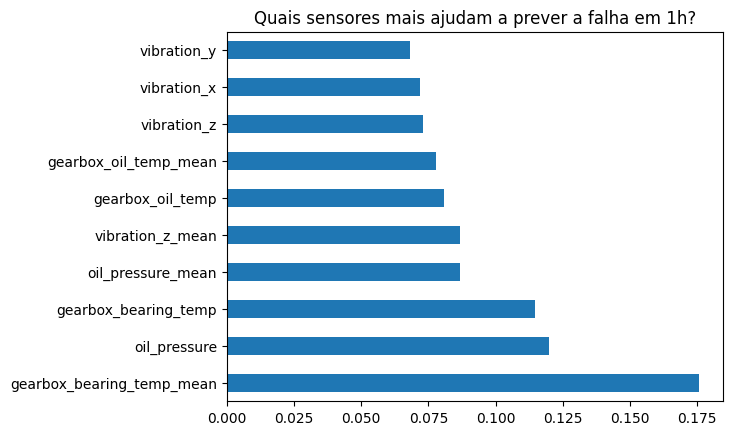

In [63]:
importances = pd.Series(model_balanced.feature_importances_, index=X_train_bal.columns)
importances.nlargest(10).plot(kind='barh')
plt.title('Quais sensores mais ajudam a prever a falha em 1h?')
plt.show()